In [221]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime as dt

import matplotlib.pyplot as plt

'''
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from yellowbrick.cluster import InterclusterDistance
'''

'\nimport seaborn as sns\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom scipy.cluster.hierarchy import dendrogram, linkage\nfrom sklearn.cluster import KMeans\nfrom yellowbrick.cluster import InterclusterDistance\n'

In [3]:
data = pd.read_csv('bank_transactions.csv', delimiter = ',')

In [4]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

In [5]:
# renaming TransactionAmount (INR) column
data.rename(columns = {"TransactionAmount (INR)":"TransactionAmount_INR"}, inplace = True)

### Formatting DateTime

In [6]:
# cleaning data
# dropping na, reformatting date times

data.dropna(inplace=True)#? doesnt change
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = data.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').time() )

### Offset the people born after 2000 and drop the Customer born before 1900

In [7]:
#TODO add plots to justify the choise made
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year < 1900].index, axis=0, inplace=True)

#  Getting your data + feature engineering

### Number of transaction per CustomerID

In [8]:
# nr_trans
nr_trans = data[['CustomerID','TransactionID']].groupby(by = 'CustomerID').count()
nr_trans.rename(columns = {'TransactionID' : 'nr_trans'}, inplace = True)

### Number of transaction that have a value larger than 100

In [9]:
# nr of transactions that exceed 100 INR
nr_trans_greater_100 = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()

### Mean of transactions for each customer

In [10]:
#  mean_trans 
mean_trans = data[['CustomerID','TransactionAmount_INR']].groupby(by='CustomerID').mean()
mean_trans.rename(columns = {'TransactionAmount_INR':'mean_trans' }, inplace = True)

### Mean of total Balance for each customerID

In [11]:
# mean_balance
mean_balance = data[['CustomerID','CustAccountBalance']].groupby(by='CustomerID').mean()
mean_balance.rename(columns = {'CustAccountBalance':'mean_balance' }, inplace = True)

### Mean difference between the mean balance and the mean transaction

In [12]:
#mean_diff. Aka Utilization
mean_diff = pd.DataFrame( mean_balance.mean_balance.sub(mean_trans.mean_trans, axis = 0) )
mean_diff.columns = ['mean_diff']

### Most frequent gender for each customerID

In [13]:
gender_most_freq = data.groupby(by = 'CustomerID').apply(lambda x: x['CustGender'].value_counts().index[0])
gender_most_freq = pd.DataFrame(gender_most_freq)
gender_most_freq.columns = ['gender_most_freq']
# converting 'M' to 1 and 'F' to 0
gender_most_freq['gender_most_freq'] = gender_most_freq['gender_most_freq'].apply(lambda x: 1 if x=='M' else 0)

In [14]:
# gender first version
#gender_most_freq = data[['CustomerID', 'CustGender']].groupby(by = 'CustomerID').apply(lambda x:x.value_counts().index[0])
#gender_most_freq.rename(columns = {'CustGender' :'gender_most_freq'}, inplace = True)

### Most frequent location 

In [15]:
# most_freq_loc new
most_freq_loc = data.groupby(by='CustomerID').apply(lambda x: x['CustLocation'].value_counts().index[0])
most_freq_loc = pd.DataFrame(most_freq_loc)
most_freq_loc.columns = [ 'most_freq_loc']

In [16]:
# most_freq_loc old, in case top is to be modified

#most_freq_loc = data[['CustomerID','CustLocation']].groupby(by='CustomerID').apply(lambda x: x.value_counts().index[0])
#most_freq_loc.rename(columns = {'CustLocation' :'most_freq_loc'}, inplace = True)

Merge all the features into one df

In [17]:
# merging nr_trans and nr_trans_greater_100 separately to ensure correct format
nr_trans_and_nr_greater_100 = nr_trans.merge(nr_trans_greater_100, on= 'CustomerID', how='left').fillna(0)
# all the dfs to be concatenated
dfs = [nr_trans_and_nr_greater_100, mean_trans, mean_balance, mean_diff, gender_most_freq, most_freq_loc]

df_7 = pd.concat(dfs, 1)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/3440457736.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_7 = pd.concat(dfs, 1)


In [72]:
df_7.to_csv('seven_params_2.csv', sep=',', encoding='utf-8', index = False)

## 20 features

In [22]:
def findMinMaxTrans(data) -> pd.DataFrame:
    return data.groupby("CustomerID").agg(  min_trans = ("TransactionAmount_INR", min),
                                            max_trans = ("TransactionAmount_INR", max),
                                            )

In [36]:
def findQuant(data, quant) -> pd.DataFrame:
    df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
    return df.rename(columns = {'TransactionAmount_INR':f'{quant}_quant_trans' })

In [47]:
def findTransValueVar(data) -> pd.DataFrame:
    var =  data.groupby('CustomerID').apply(lambda group: group['TransactionAmount_INR'].nunique()/len(group['TransactionAmount_INR']))
    return pd.DataFrame(var).rename(columns={0:'trans_val_var'})

In [53]:
def findMinMaxDiffBalance(data) -> pd.DataFrame:
    df =  data.groupby("CustomerID").agg(  min_balance = ("CustAccountBalance", min),
                                            max_balance = ("CustAccountBalance", max),
                                            )
    df['diff_balance'] =  df.max_balance.sub(df.min_balance, axis = 0)
    return df

In [80]:

def findTransactionTimes(data) -> pd.DataFrame:
    hours_data = data[['CustomerID', 'TransactionTime']]
    hours_data['TransactionTime'] = pd.to_datetime((hours_data['TransactionTime']).astype(str)).dt.hour
    mean_hour = hours_data.groupby(by = 'CustomerID').mean()
    max_hour = hours_data.groupby(by = 'CustomerID').max()
    min_hour = hours_data.groupby(by = 'CustomerID').min()
    most_freq_hour = hours_data.groupby(by = 'CustomerID')['TransactionTime'].apply(lambda x: x.value_counts().index[0])
    most_freq_hour = pd.DataFrame(most_freq_hour)

    df = pd.concat([mean_hour, max_hour, min_hour, most_freq_hour], 1)
    df.columns = ['mean_hour', 'max_hour', 'min_hour', 'most_freq_hour']

    return df

In [165]:
def findTransactionDate(data) -> pd.DataFrame:
    dates = data[['CustomerID', 'TransactionDate']]
    #dates['dt'] = pd.to_datetime(dates.TransactionDate.astype(str))
    most_freq_weekday = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.weekday.value_counts().index[0])
    most_freq_month = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.value_counts().index[0])
    nr_diff_months = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.nunique())

    frame = {'most_freq_weekday': most_freq_weekday, 'most_freq_month': most_freq_month, 'nr_diff_months': nr_diff_months}
    df = pd.DataFrame(frame)
    return df

In [112]:
def findNrLocs(data) -> pd.DataFrame:
    df =  pd.DataFrame(data.groupby(by = 'CustomerID')['CustLocation'].nunique())
    df.columns = ['nr_diff_locs']
    return df

In [113]:
def findNrDOB(data) -> pd.DataFrame:
    df = pd.DataFrame(data.groupby(by = 'CustomerID')['CustomerDOB'].nunique())
    df.columns = ['nr_diff_dob']
    return df

In [206]:
def findMeanAge(data):
    df = sub_data[['CustomerID', 'TransactionDate', 'CustomerDOB']].groupby(by = 'CustomerID').apply(lambda group: (group.TransactionDate-group.CustomerDOB ).astype('timedelta64[Y]').mean() )# might have to select in data already
    df = pd.DataFrame(df)
    df.columns = ['mean_age_trans']
    return df

In [171]:
def findNrTrans1K(data) -> pd.DataFrame:
    df = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
    df.columns = ['trans_greater_1k']
    return df

In [141]:
def findNrBalance100K(data) -> pd.DataFrame:
    df = data[['CustomerID','CustAccountBalance']].query("CustAccountBalance > 100").groupby(by= "CustomerID").count()
    df.columns = ['balance_greater_100k']
    return df

In [198]:
def findTrans_ValBalRatio(data) -> pd.DataFrame:
    mean_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).mean())
    max_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).min())
    frame = {'mean_ratio': mean_ratio, 'max_ratio': max_ratio}
    df = pd.DataFrame(frame)
    return df

In [207]:
def features_20(data): 
    
    #min and max of transaction for each customerID
    min_max_trans = findMinMaxTrans(data)
    #quantiles of transactions for each customerID
    quant_75_trans = findQuant(data, 0.75)
    quant_25_trans = findQuant(data, 0.25)
    # ratio of unique transactions amounts for customerID
    trans_val_var = findTransValueVar(data)
    
    #min and max of balance for each customerID
    min_max_diff_balance = findMinMaxDiffBalance(data)
    
    # get max_hour, min_hour, mean_hour and most frequent hour of transactions for customerID
    transaction_times = findTransactionTimes(data)
    
    # get most frequent weekdy, most frequent month, and number of differnt months for transactions done by the customerID
    transaction_dates = findTransactionDate(data)
    
    # number of different locations from which a customerID has made transactions
    nr_diff_locs = findNrLocs(data)
    
    # nr of unique dates of birth for customerID, might roughly be the number of people using the account
    nr_diff_dob = findNrDOB(data) 
    
    # mean age of customerID at times of transaction (in years)
    age_mean = findMeanAge(data)
    
    # number transactions that exceed 1000 INR
    nr_trans_1k = findNrTrans1K(data) # dimension!
    
    # number transaction instances at which the customer balance was > 100000
    nr_balance_100k = findNrBalance100K(data)
    
    # transaction amount/balance ratio , return the mean and max of this ratio
    trans_valbalratio = findTrans_ValBalRatio(data)

    # merging dataframes with different dimensionality separately
    pre_df = min_max_trans.merge(nr_trans_1k, on = 'CustomerID', how = 'left').fillna(0)
    pre_df = pre_df.merge(nr_balance_100k, on = 'CustomerID', how = 'left').fillna(0)

    df_all = pd.concat([pre_df, quant_75_trans, quant_25_trans, trans_val_var, min_max_diff_balance, transaction_times, transaction_dates, 
                        nr_diff_locs, nr_diff_dob, age_mean, trans_valbalratio], 1)
    
    return df_all    

    # these were originally included:
    #avg_nr_trans_perday = group.groupby(by= 'TransactionDate').count().mean()
    #first_freq_loc = group['CustLocation'].agg(lambda x:x.value_counts().index[0])
    #std_balance = group['CustAccountBalance'].std()
    

In [173]:
data_20 = features_20(data)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/1643579581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [205]:
data_20

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,min_hour,most_freq_hour,most_freq_weekday,most_freq_month,nr_diff_months,nr_diff_locs,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,1,12,0,9,1,2,2,28.0,0.074556,0.002962
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,20,20,6,8,1,1,1,22.0,0.061931,0.061931
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,15,15,4,1,2,1,2,27.0,0.016472,0.001545
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,17,17,3,9,1,1,1,26.0,0.060462,0.060462
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,14,14,3,8,1,1,1,51.0,0.057433,0.057433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,691.0,691.0,1.0,1.0,691.00,691.00,1.0,133067.23,133067.23,0.00,...,0,0,4,7,1,1,1,25.0,0.005193,0.005193
C9099877,222.0,222.0,1.0,1.0,222.00,222.00,1.0,96063.46,96063.46,0.00,...,12,12,3,9,1,1,1,20.0,0.002311,0.002311
C9099919,126.0,126.0,1.0,1.0,126.00,126.00,1.0,5559.75,5559.75,0.00,...,12,12,3,8,1,1,1,22.0,0.022663,0.022663


In [203]:
data_20.to_csv('twenty_params_2.csv', sep = ',', encoding = 'utf-8')

# 2.2 Choose your features (variables)!

### dim reduction 
this is what i had tried to do yesterday, but on possibly wrong data

In [208]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [209]:
data_20 = pd.read_csv('twenty_params_2.csv', delimiter = ',').drop(['Unnamed: 0'], axis = 1)
data_7 = pd.read_csv('seven_params_2.csv', delimiter = ',').reset_index(drop=True)
data_27 = pd.concat([data_20, data_7], axis = 1)

In [210]:
data_27.fillna(0, inplace = True)
data_27.replace([np.inf, -np.inf], 0, inplace=True)

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,mean_age_trans,mean_ratio,max_ratio,nr_trans,TransactionAmount_INR,mean_trans,mean_balance,mean_diff,gender_most_freq,most_freq_loc
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,28.0,0.074556,0.002962,0.0,0.0,0.0,0.00,0.00,0.0,0
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,22.0,0.061931,0.061931,0.0,0.0,0.0,0.00,0.00,0.0,0
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,27.0,0.016472,0.001545,0.0,0.0,0.0,0.00,0.00,0.0,0
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,26.0,0.060462,0.060462,0.0,0.0,0.0,0.00,0.00,0.0,0
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,51.0,0.057433,0.057433,0.0,0.0,0.0,0.00,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000000,0.000000,1.0,1.0,691.0,133067.23,132376.23,1.0,BHIWANDI
839077,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000000,0.000000,1.0,1.0,222.0,96063.46,95841.46,1.0,BANGALORE
839078,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000000,0.000000,1.0,1.0,126.0,5559.75,5433.75,1.0,GUNTUR
839079,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.0,0.000000,0.000000,1.0,0.0,50.0,35295.92,35245.92,1.0,CHENNAI


In [ ]:
places = pd.get_dummies(data_27['most_freq_loc'])
places.shape # this results in 7894 extra columns, so left it for now

In [216]:
cols_for_norm = data_27.columns[0:28] # for now selecting only numerical values
data_num = data_27[cols_for_norm]

In [217]:
pca = PCA(n_components=5)
data_pca = pca.fit_transform(data_num)

In [218]:
data_pca.var()
pca.explained_variance_

array([6.45399458e+11, 6.21960374e+11, 1.38879144e+11, 7.51594741e+07,
       4.29175375e+07])

In [219]:
from sklearn.cluster import KMeans

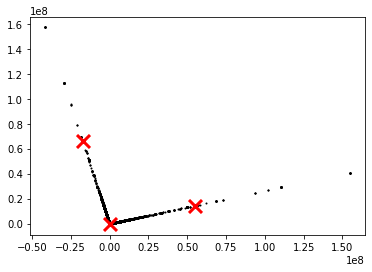

In [222]:
kmeans = KMeans(n_clusters=3, init='random', n_init=4, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(data_pca)

plt.plot(data_pca[:, 0], data_pca[:, 1], "k.", markersize=2)
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="r",
    zorder=10,
)